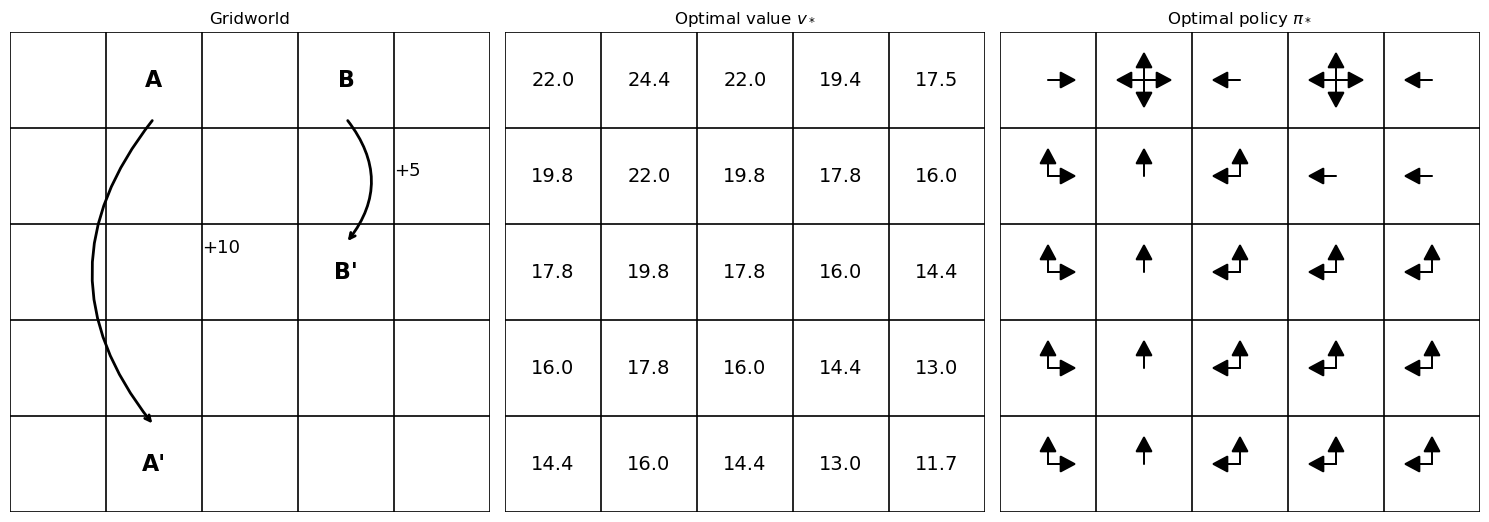

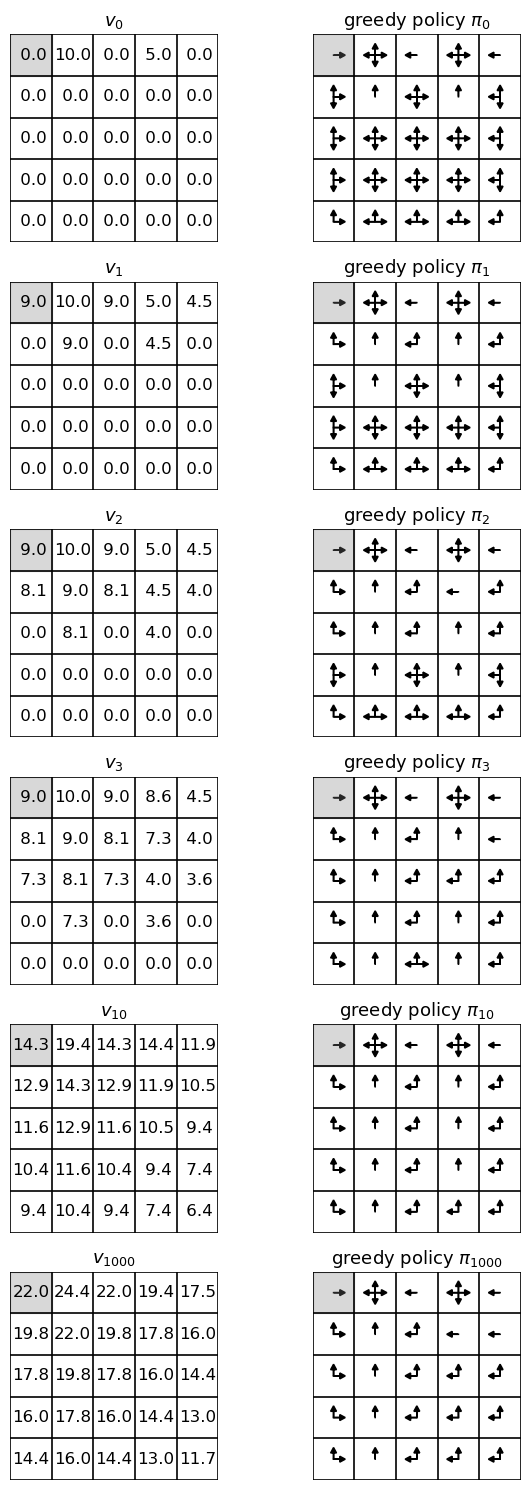

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# environment class (same as before)
class SimplifiedGridworldEnvironment:
    def __init__(self, world_size=5):
        self.world_size = world_size
        self.special_location_a = (0, 1)
        self.special_exit_a = (4, 1)
        self.special_reward_a = 10
        self.special_location_b = (0, 3)
        self.special_exit_b = (2, 3)
        self.special_reward_b = 5
        self.movement_directions = {
            'north': (-1, 0),
            'south': (1, 0),
            'east': (0, 1),
            'west': (0, -1)
        }
        self.available_actions = list(self.movement_directions.keys())
    
    def compute_transition(self, current_row, current_col, chosen_action):
        if (current_row, current_col) == self.special_location_a:
            return (self.special_exit_a[0], self.special_exit_a[1], self.special_reward_a)
        if (current_row, current_col) == self.special_location_b:
            return (self.special_exit_b[0], self.special_exit_b[1], self.special_reward_b)
        row_change, col_change = self.movement_directions[chosen_action]
        resulting_row = current_row + row_change
        resulting_col = current_col + col_change
        if (resulting_row < 0 or resulting_row >= self.world_size or 
            resulting_col < 0 or resulting_col >= self.world_size):
            resulting_row = current_row
            resulting_col = current_col
            immediate_reward = -1
        else:
            immediate_reward = 0
        return resulting_row, resulting_col, immediate_reward

# policy evaluation of the random equiprobable policy
def policy_evaluation_snapshots(env, discount, iteration_list):
    """
    evaluate the equiprobable random policy iteratively
    """
    # equiprobable random policy: each action has probability 0.25
    uniform_prob = 0.25
    
    state_values = np.zeros((env.world_size, env.world_size))
    value_history = []
    max_iters = max(iteration_list)
    
    for curr_iter in range(max_iters + 1):
        next_values = np.zeros_like(state_values)
        for row in range(env.world_size):
            for col in range(env.world_size):
                expected_value = 0
                # sum over all actions weighted by policy (0.25 each)
                for action in env.available_actions:
                    next_row, next_col, reward = env.compute_transition(row, col, action)
                    expected_value += uniform_prob * (reward + discount * state_values[next_row, next_col])
                next_values[row, col] = expected_value
        state_values = next_values
        if curr_iter in iteration_list:
            value_history.append((curr_iter, state_values.copy()))
    
    return value_history

def extract_greedy_policy_with_ties(env, state_values, discount):
    # extract greedy policy from current value function
    policy = {}
    for row in range(env.world_size):
        for col in range(env.world_size):
            action_values = {}
            for action in env.available_actions:
                next_row, next_col, reward = env.compute_transition(row, col, action)
                action_values[action] = reward + discount * state_values[next_row, next_col]
            best_val = max(action_values.values())
            optimal_actions = [a for a,v in action_values.items() if abs(v - best_val) < 1e-8]
            policy[(row, col)] = optimal_actions
    return policy

def plot_value_and_policy(ax_val, ax_pi, values, policy, env, cell_format="{:4.1f}", highlight=None):
    size = env.world_size
    # draw value grid
    for i in range(size+1):
        ax_val.axhline(i, color='black', lw=1.2)
        ax_val.axvline(i, color='black', lw=1.2)
    for row in range(size):
        for col in range(size):
            x = col + 0.5
            y = size - row - 0.5
            s = cell_format.format(values[row, col])
            ax_val.text(x, y, s, ha='center', va='center', fontsize=12)
            if highlight and (row, col) in highlight:
                rect = plt.Rectangle((col, size-row-1), 1, 1, color='grey', alpha=0.3)
                ax_val.add_patch(rect)
    ax_val.set_xlim(0, size)
    ax_val.set_ylim(0, size)
    ax_val.set_aspect('equal')
    ax_val.axis('off')
    
    # draw policy grid/arrows
    arrow_defs = {'north':(0,0.28),'south':(0,-0.28),'east':(0.28,0),'west':(-0.28,0)}
    arrowprops = dict(head_width=0.14, head_length=0.13, lw=1.1, fc='black', ec='black', length_includes_head=True)
    for i in range(size+1):
        ax_pi.axhline(i, color='black', lw=1.2)
        ax_pi.axvline(i, color='black', lw=1.2)
    for row in range(size):
        for col in range(size):
            x = col + 0.5
            y = size - row - 0.5
            act_list = policy[(row, col)]
            for a in act_list:
                dx, dy = arrow_defs[a]
                ax_pi.arrow(x, y, dx, dy, **arrowprops)
            if highlight and (row, col) in highlight:
                rect = plt.Rectangle((col, size-row-1), 1, 1, color='grey', alpha=0.3)
                ax_pi.add_patch(rect)
    ax_pi.set_xlim(0, size)
    ax_pi.set_ylim(0, size)
    ax_pi.set_aspect('equal')
    ax_pi.axis('off')

def plot_figure_4_1_snapshots(env, value_history, discount):
    n = len(value_history)
    fig, axs = plt.subplots(n, 2, figsize=(7, 2.5*n))
    for idx, (k, values) in enumerate(value_history):
        policy = extract_greedy_policy_with_ties(env, values, discount)
        ax_val = axs[idx,0]
        ax_pi = axs[idx,1]
        plot_value_and_policy(ax_val, ax_pi, values, policy, env)
        ax_val.set_title(r"$v_{" + str(k) + r"}$ for random policy", fontsize=13)
        ax_pi.set_title(r"greedy policy w.r.t. $v_{" + str(k) + r"}$", fontsize=13)
    plt.tight_layout()
    plt.show()

# ============ run all ============#
if __name__ == "__main__":
    env = SimplifiedGridworldEnvironment(world_size=5)
    discount = 0.9
    # textbook shows k=0,1,2,3,10,∞
    iteration_list = [0, 1, 2, 3, 10, 1000]
    value_history = policy_evaluation_snapshots(env, discount, iteration_list)
    plot_figure_4_1_snapshots(env, value_history, discount)
